In [2]:
import sys
import os
import time

sys.path.insert(0,'../../../')
sys.path.insert(0,'../../../py')

import parameters
import utilities
import spectrogram_utilities
import output_utilities
import spectrogram_output_visualiser
import spectrogram_cuts_db_creation

import numpy as np
import pandas as pd
import h5py

from sklearn import preprocessing
from sklearn.cluster import KMeans, MeanShift

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# matplotlib.get_backend()
%matplotlib inline

awd_event = 1
site = parameters.sites[0]

### Loading database

In [4]:
_data, probs, events, f_cut_length, t_cut_length = spectrogram_cuts_db_creation.load_spectrogram_cuts_db(awd_event, site, database_name='spectrogram_cuts.h5', verbose=True, noise=False)


Loading spectrogram cuts from database for awdEvent1/marion


KeyError: "Can't open attribute (can't locate attribute: 'site')"

(10820, 22563)


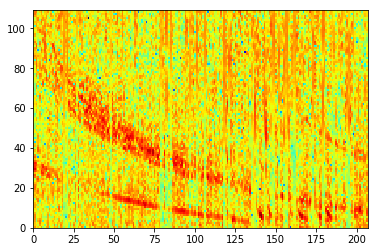

In [5]:
print(_data.shape)
plt.pcolormesh(_data[np.random.randint(len(_data))].reshape((f_cut_length,t_cut_length)), cmap='jet')

## Clustering

#### Reduce dimensionality

In [7]:
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA

pca = PCA(0.9)
data = preprocessing.scale(_data)
data = pca.fit_transform(data)

#### Apply KMeans with 3 clusters

In [8]:
kmeans = KMeans(n_clusters=3,max_iter=1000)
kmeans.fit(data)
# meanshift = MeanShift().fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

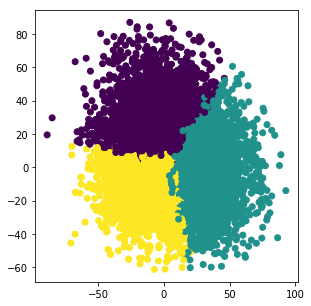

In [9]:
# fig = plt.figure(figsize=(8, 6))
# ax = Axes3D(fig)
# ax.scatter(data[:, 0], data[:, 1], data[:, 2],c=kmeans.labels_)


plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.scatter(data[:, 0], data[:, 1], c=kmeans.labels_)
# plt.subplot(1,3,2)
# plt.scatter(data[:, 0], data[:, 2], c=kmeans.labels_)
# plt.subplot(1,3,3)
# plt.scatter(data[:, 1], data[:, 2], c=kmeans.labels_)

In [10]:
# kmeans.cluster_centers_ = np.array([[2,-2],[-2,2]])
# kmeans.labels_ = np.array([0,1])
# data = np.array([[-2,1],[-1,1],[-1,3],[2,-3],[3,-3],[3,0]])

#### Find the datapoints closest to each centroid

[[-7.23461749e+00  2.78552907e+01 -5.34216302e-02 ... -6.32100878e-03
   1.06199339e-02 -7.73176936e-03]
 [ 3.03425379e+01 -3.73534598e+00  4.77389604e+00 ...  4.61272708e-03
  -6.33441503e-03  5.72705730e-04]
 [-1.18647404e+01 -1.29894921e+01 -2.44806839e+00 ...  9.94287199e-04
  -2.40482937e-03  3.84626302e-03]]
[5286, 5291, 777]
[[-4.21386668e+00  2.01121199e+01 -1.26509369e+01 ...  6.38805033e-02
   4.88708499e-01 -5.88374914e-01]
 [ 2.09457739e+01 -8.33252005e-01 -3.85411843e-01 ... -5.38995197e-01
   1.58432431e+00  6.74320590e-01]
 [-1.09808690e+01 -9.29768802e+00 -1.56684491e+01 ... -1.08540292e+00
   5.13549853e-03  1.10591619e+00]]


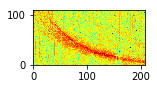

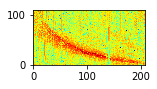

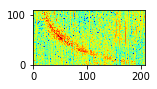

In [11]:
index = []
for centroid in kmeans.cluster_centers_:
    norm = np.linalg.norm(data-centroid, axis=1)
#     print(norm)
    index.append(np.argmin(norm))
print(kmeans.cluster_centers_)
print(index)
print(data[index])
for i in index:
    plt.figure(figsize=(2,1))
    plt.pcolormesh(_data[i].reshape((f_cut_length,t_cut_length)), cmap='jet')

kernels = _data[index]

#### Apply Match filter on the data using the kernels

(257, 853) 61943 88.51456230722295 527
(257, 853) 61961 90.82462324253346 545
(257, 853) 66212 57.92156413919552 531


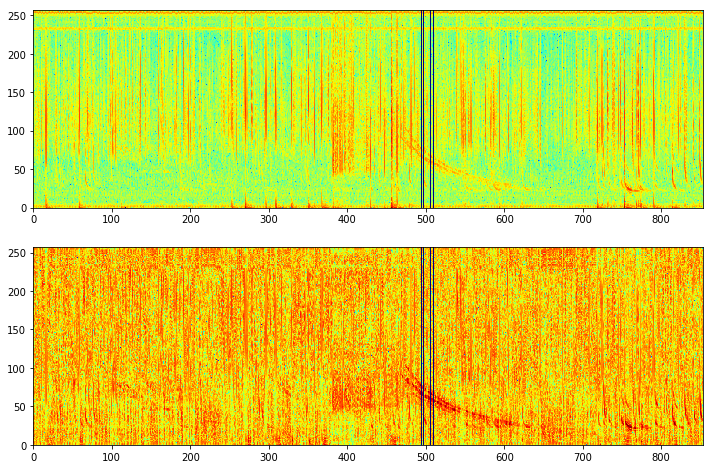

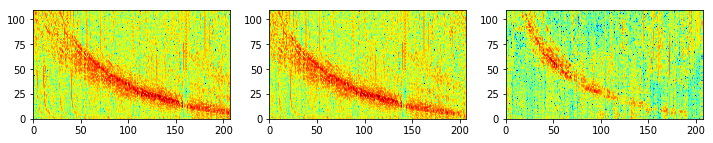

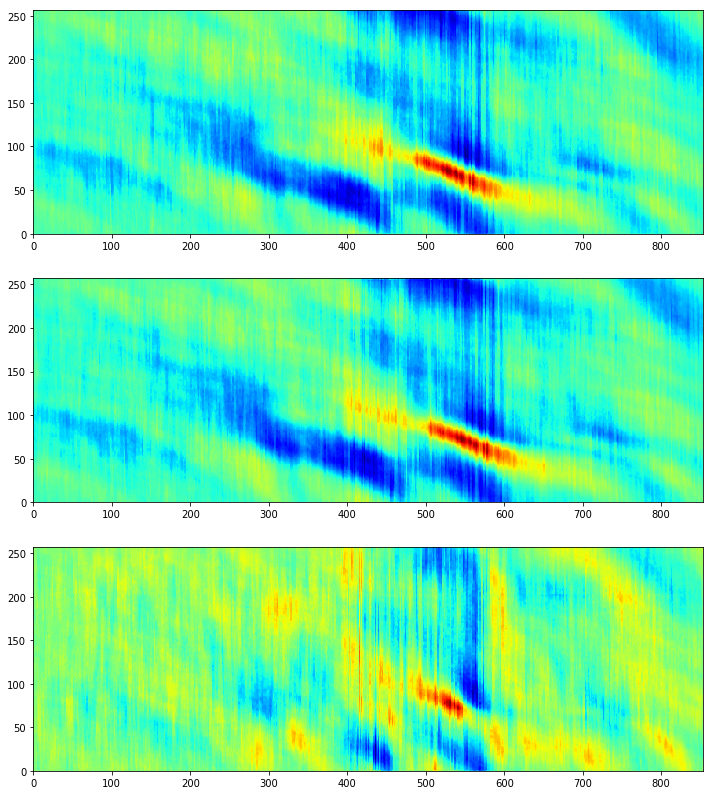

In [66]:
from scipy import signal
file = utilities.random_file(awd_event, site)
indexed_output , time, freq, _spec = spectrogram_output_visualiser.spectrogram_and_output(awd_event, site, file, output=True, verbose=False, zscore=False)
indexed_output , time, freq, spec = spectrogram_output_visualiser.spectrogram_and_output(awd_event, site, file, output=True, verbose=False, zscore=True)
plt.figure(figsize=(12,8))   
plt.subplot(2,1,1)
plt.pcolormesh(_spec, cmap='jet')   
plt.subplot(2,1,2)
plt.pcolormesh(spec, cmap='jet')
plt.figure(figsize=(12,2))
for k in range(len(kernels)):
    plt.subplot(1,3,k+1)
    plt.pcolormesh(kernels[k].reshape((f_cut_length,t_cut_length)), cmap='jet')

plt.figure(figsize=(12,14))
corrs = []
for k in range(len(kernels)):
    corr = signal.correlate(spec, kernels[k].reshape((f_cut_length,t_cut_length)),mode='same')
#     corrs.append(corr)
    corr = signal.medfilt(corr,kernel_size=3)
    print(corr.shape,np.argmax(corr),corr.max(),np.argmax(corr)%corr.shape[1])
    plt.subplot(3,1,k+1)
    plt.pcolormesh(corr, cmap='jet')

In [ ]:
from scipy import signal
plt.figure(figsize=(12,14))
for c in range(len(corrs)):
    _corr = signal.medfilt(corrs[c],kernel_size=3)
    plt.subplot(3,1,c+1)
    plt.pcolormesh(_corr, cmap='jet')